## Exploring forecasting various home price metrics with pytorch
see: 
- https://github.com/jdb78/pytorch-forecasting
- https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html 


In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter('ignore')

# imports for training
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# import dataset, network to train and metric to optimize
from pytorch_forecasting import (
    Baseline,
    TimeSeriesDataSet,
    TemporalFusionTransformer,
    QuantileLoss,
)
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer, NaNLabelEncoder
import torch

# standard imports
import numpy as np
import pandas as pd

#### Load Data

**load data:** this is pandas dataframe with at least a column for
* the target (what you want to predict)
* the timeseries ID (which should be a unique string to identify each timeseries)
* the time of the observation (which should be a monotonically increasing integer)

In [2]:
data = pd.read_csv("data/nn_monthly_data.csv.gz", parse_dates=["period_begin", "period_end"])
#data.head()

In [3]:
# add time index
data["time_idx"] = data["period_end"].dt.year * 12 + data["period_end"].dt.month
data["time_idx"] -= data["time_idx"].min()
data["month"] = data["period_end"].dt.month.astype(str).astype("category")

In [4]:
cols = [
    "period_end",
    "region_type",
    "region_type_id",
    "is_seasonally_adjusted",
    "property_type_id", # leave property type  
    "state_x",
    "fips",
    "state_y",
    "state_fips",
    "table_id",
    "period_duration",
    "city",
    "state_code",
    "parent_metro_region",
    "parent_metro_region_metro_code",
    "median_ppsf",
    "avg_sale_to_list",
    "last_updated",
    "county"
]



In [5]:
data.drop(columns=cols, inplace=True)
# drop the yoy and mom columns
data.drop(list(data.filter(regex = 'yoy|mom')), axis = 1, inplace = True)

Original Columns 

`Index(['county_fips', 'period_begin', 'period_end', 'period_duration',
       'region_type', 'region_type_id', 'table_id', 'is_seasonally_adjusted',
       'region', 'city', 'state', 'state_code', 'property_type',
       'property_type_id', 'median_sale_price', 'median_sale_price_mom',
       'median_sale_price_yoy', 'median_list_price', 'median_list_price_mom',
       'median_list_price_yoy', 'median_ppsf', 'median_ppsf_mom',
       'median_ppsf_yoy', 'median_list_ppsf', 'median_list_ppsf_mom',
       'median_list_ppsf_yoy', 'homes_sold', 'homes_sold_mom',
       'homes_sold_yoy', 'pending_sales', 'pending_sales_mom',
       'pending_sales_yoy', 'new_listings', 'new_listings_mom',
       'new_listings_yoy', 'inventory', 'inventory_mom', 'inventory_yoy',
       'months_of_supply', 'months_of_supply_mom', 'months_of_supply_yoy',
       'median_dom', 'median_dom_mom', 'median_dom_yoy', 'avg_sale_to_list',
       'avg_sale_to_list_mom', 'avg_sale_to_list_yoy', 'sold_above_list',
       'sold_above_list_mom', 'sold_above_list_yoy', 'price_drops',
       'price_drops_mom', 'price_drops_yoy', 'off_market_in_two_weeks',
       'off_market_in_two_weeks_mom', 'off_market_in_two_weeks_yoy',
       'parent_metro_region', 'parent_metro_region_metro_code', 'last_updated',
       'county', 'date', 'unemployment_rate', 'state_x', 'fips', 'year',
       'state_y', 'state_fips', 'income_tax_low', 'income_tax_high',
       'corp_income_tax_low', 'corp_income_tax_high', 'time_idx', 'month'],
      dtype='object')`

In [6]:
#data.info()
#data.head()

In [7]:
data["county_fips"] = data["county_fips"].astype(str).astype("category")

#### Create Dataset & Dataloaders

In [8]:
# define the dataset, i.e. add metadata to pandas dataframe for the model to understand it
max_encoder_length = 60
max_prediction_length = 12
training_cutoff = data["time_idx"].max() - max_prediction_length  # day for cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",  # column name of time of observation
    target="median_sale_price",  # column name of target to predict
    group_ids=[
        "county_fips",
        "region",
        "state",
        "property_type",
    ],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID
    static_categoricals=["region", "property_type", "state", "county_fips"],
    static_reals=[],
    # covariates known and unknown in the future to inform prediction
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=[
        "year",
        "time_idx",
        "income_tax_low",
        "income_tax_high",
        "corp_income_tax_low",
        "corp_income_tax_high",
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "median_sale_price",
        "median_list_price",
        "median_list_ppsf",
        "homes_sold",
        "pending_sales",
        "new_listings",
        "inventory",
        "months_of_supply",
        "median_dom",
        "sold_above_list",
        "off_market_in_two_weeks",
    ],
    add_relative_time_idx=True,
    allow_missing_timesteps=True,
    categorical_encoders={
        "region": NaNLabelEncoder(add_nan=True),
        "county_fips": NaNLabelEncoder(add_nan=True),
    },
)
# target_normalizer=GroupNormalizer(
#     groups=["agency", "sku"], transformation="softplus"
# ),  # use softplus and normalize by group
# add_target_scales=True,
# add_encoder_length=True,
# )


In [9]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    predict=True,
    min_prediction_idx=training.index.time.max() + 1,
    stop_randomization=True,
)

In [10]:
# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=2
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=2 # double check factor of 10 will work
)

#### Baseline Model for comparison

In [11]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()
# baseline with monthly data = 54858.94140625

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical

54858.94140625

#### Find Optimal Learning Rate

In [12]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=16,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=10,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 225.8k


/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
Finding best initial lr:  13%|█▎        | 13/100 [00:07<00:50,  1.73it/s]/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - con

suggested learning rate: 0.041686938347033554


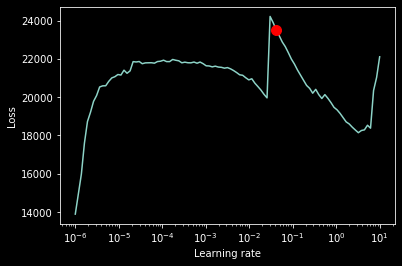

In [17]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

#### Train Model

In [13]:
# configure network and trainer
# create PyTorch Lightning Trainer with early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=4, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.15,
    limit_train_batches=30,  # 30 batches per epoch
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
# define network to train - the architecture is mostly inferred from the dataset,
# so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=58,
    attention_head_size=4, # play around with this param - can go up to 4 depending on sizeof data 
    dropout=0.1,
    hidden_continuous_size=56,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=0,
    # optimizer parameters
    learning_rate=0.007, #change back to best_tft
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 744.2k


In [15]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 212 K 
3  | prescalers                         | ModuleDict                      | 2.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 1.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 262 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 97.9 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 13.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 13.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 13.8

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:05<?, ?it/s]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 0:  74%|███████▎  | 25/34 [00:27<00:09,  1.11s/it, loss=1.97e+04, v_num=11, train_loss_step=1.24e+4]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 0:  88%|████████▊ | 30/34 [00:32<00:04,  1.09s/it, loss=1.6e+04, v_num=11, train_loss_step=1.04e+4] 

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 1:  76%|███████▋  | 26/34 [01:20<00:24,  3.08s/it, loss=1.05e+04, v_num=11, train_loss_step=9.3e+3, val_loss=2.06e+4, train_loss_epoch=1.96e+4] 

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 1:  88%|████████▊ | 30/34 [01:23<00:11,  2.79s/it, loss=1.01e+04, v_num=11, train_loss_step=9.04e+3, val_loss=2.06e+4, train_loss_epoch=1.96e+4]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 2: 100%|██████████| 34/34 [01:42<00:00,  3.00s/it, loss=1.01e+04, v_num=11, train_loss_step=9.04e+3, val_loss=1.59e+4, train_loss_epoch=1.04e+4]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 2:  79%|███████▉  | 27/34 [02:12<00:34,  4.90s/it, loss=9.1e+03, v_num=11, train_loss_step=9.03e+3, val_loss=1.59e+4, train_loss_epoch=1.04e+4] 

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 2:  88%|████████▊ | 30/34 [02:15<00:18,  4.52s/it, loss=8.7e+03, v_num=11, train_loss_step=7.43e+3, val_loss=1.59e+4, train_loss_epoch=1.04e+4] 

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 3:  88%|████████▊ | 30/34 [03:10<00:25,  6.34s/it, loss=9.36e+03, v_num=11, train_loss_step=1.04e+4, val_loss=1.46e+4, train_loss_epoch=9.03e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 4:  21%|██        | 7/34 [03:42<14:19, 31.85s/it, loss=9.18e+03, v_num=11, train_loss_step=1.21e+4, val_loss=1.41e+4, train_loss_epoch=9.46e+3]   

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 4:  88%|████████▊ | 30/34 [04:04<00:32,  8.17s/it, loss=8.91e+03, v_num=11, train_loss_step=7.76e+3, val_loss=1.41e+4, train_loss_epoch=9.46e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 5: 100%|██████████| 34/34 [04:22<00:00,  7.72s/it, loss=8.91e+03, v_num=11, train_loss_step=7.76e+3, val_loss=1.38e+4, train_loss_epoch=8.94e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 5:  88%|████████▊ | 30/34 [04:55<00:39,  9.84s/it, loss=8.67e+03, v_num=11, train_loss_step=8.2e+3, val_loss=1.38e+4, train_loss_epoch=8.94e+3]   

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 6:  88%|████████▊ | 30/34 [05:45<00:46, 11.51s/it, loss=8.23e+03, v_num=11, train_loss_step=7.81e+3, val_loss=1.36e+4, train_loss_epoch=8.66e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 7:  88%|████████▊ | 30/34 [06:39<00:53, 13.33s/it, loss=8.26e+03, v_num=11, train_loss_step=7.75e+3, val_loss=1.37e+4, train_loss_epoch=8.29e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 8:  88%|████████▊ | 30/34 [07:31<01:00, 15.04s/it, loss=8.53e+03, v_num=11, train_loss_step=7.58e+3, val_loss=1.36e+4, train_loss_epoch=8.53e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 9: 100%|██████████| 34/34 [07:48<00:00, 13.79s/it, loss=8.53e+03, v_num=11, train_loss_step=7.58e+3, val_loss=1.36e+4, train_loss_epoch=8.49e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 9:  32%|███▏      | 11/34 [08:03<16:51, 43.99s/it, loss=7.99e+03, v_num=11, train_loss_step=7.03e+3, val_loss=1.36e+4, train_loss_epoch=8.49e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 9:  88%|████████▊ | 30/34 [08:21<01:06, 16.72s/it, loss=8.16e+03, v_num=11, train_loss_step=8.31e+3, val_loss=1.36e+4, train_loss_epoch=8.49e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 10:  53%|█████▎    | 18/34 [09:00<08:00, 30.01s/it, loss=7.89e+03, v_num=11, train_loss_step=7.61e+3, val_loss=1.3e+4, train_loss_epoch=8.09e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 10:  88%|████████▊ | 30/34 [09:11<01:13, 18.38s/it, loss=7.91e+03, v_num=11, train_loss_step=1.02e+4, val_loss=1.3e+4, train_loss_epoch=8.09e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 11: 100%|██████████| 34/34 [09:28<00:00, 16.72s/it, loss=7.91e+03, v_num=11, train_loss_step=1.02e+4, val_loss=1.33e+4, train_loss_epoch=7.92e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 11:  88%|████████▊ | 30/34 [10:02<01:20, 20.08s/it, loss=7.92e+03, v_num=11, train_loss_step=8.43e+3, val_loss=1.33e+4, train_loss_epoch=7.92e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 12:  88%|████████▊ | 30/34 [10:55<01:27, 21.84s/it, loss=7.78e+03, v_num=11, train_loss_step=7.52e+3, val_loss=1.27e+4, train_loss_epoch=7.86e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 13:  88%|████████▊ | 30/34 [11:46<01:34, 23.54s/it, loss=8.15e+03, v_num=11, train_loss_step=9.13e+3, val_loss=1.31e+4, train_loss_epoch=7.91e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 14:  65%|██████▍   | 22/34 [12:29<06:48, 34.06s/it, loss=7.71e+03, v_num=11, train_loss_step=7.28e+3, val_loss=1.25e+4, train_loss_epoch=7.97e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 14:  88%|████████▊ | 30/34 [12:36<01:40, 25.22s/it, loss=7.63e+03, v_num=11, train_loss_step=7.48e+3, val_loss=1.25e+4, train_loss_epoch=7.97e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 15: 100%|██████████| 34/34 [12:53<00:00, 22.76s/it, loss=7.63e+03, v_num=11, train_loss_step=7.48e+3, val_loss=1.26e+4, train_loss_epoch=7.67e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 15:  88%|████████▊ | 30/34 [13:28<01:47, 26.94s/it, loss=8.07e+03, v_num=11, train_loss_step=6.46e+3, val_loss=1.26e+4, train_loss_epoch=7.67e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 16:  44%|████▍     | 15/34 [14:04<17:49, 56.29s/it, loss=7.88e+03, v_num=11, train_loss_step=8.29e+3, val_loss=1.22e+4, train_loss_epoch=7.99e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 16:  88%|████████▊ | 30/34 [14:18<01:54, 28.61s/it, loss=7.72e+03, v_num=11, train_loss_step=8.5e+3, val_loss=1.22e+4, train_loss_epoch=7.99e+3] 

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 17:  88%|████████▊ | 30/34 [15:09<02:01, 30.30s/it, loss=7.87e+03, v_num=11, train_loss_step=7.03e+3, val_loss=1.2e+4, train_loss_epoch=7.82e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 18:  74%|███████▎  | 25/34 [15:55<05:43, 38.22s/it, loss=7.8e+03, v_num=11, train_loss_step=7.25e+3, val_loss=1.25e+4, train_loss_epoch=7.95e+3]   

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 18:  88%|████████▊ | 30/34 [16:00<02:08, 32.01s/it, loss=8.17e+03, v_num=11, train_loss_step=8.72e+3, val_loss=1.25e+4, train_loss_epoch=7.95e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 19:   9%|▉         | 3/34 [16:24<2:49:38, 328.33s/it, loss=8.34e+03, v_num=11, train_loss_step=8.78e+3, val_loss=1.22e+4, train_loss_epoch=8.09e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 19:  41%|████      | 14/34 [16:35<23:41, 71.08s/it, loss=8.45e+03, v_num=11, train_loss_step=8.19e+3, val_loss=1.22e+4, train_loss_epoch=8.09e+3]  

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 19:  88%|████████▊ | 30/34 [16:49<02:14, 33.67s/it, loss=8.1e+03, v_num=11, train_loss_step=6.64e+3, val_loss=1.22e+4, train_loss_epoch=8.09e+3] 

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 20:  88%|████████▊ | 30/34 [17:38<02:21, 35.30s/it, loss=8.57e+03, v_num=11, train_loss_step=8.19e+3, val_loss=1.16e+4, train_loss_epoch=8.03e+3]   

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 21:  71%|███████   | 24/34 [18:22<07:39, 45.93s/it, loss=8.14e+03, v_num=11, train_loss_step=7.75e+3, val_loss=1.15e+4, train_loss_epoch=8.46e+3]   

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 21:  88%|████████▊ | 30/34 [18:27<02:27, 36.93s/it, loss=8.01e+03, v_num=11, train_loss_step=7.35e+3, val_loss=1.15e+4, train_loss_epoch=8.46e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 22:  71%|███████   | 24/34 [19:11<07:59, 47.98s/it, loss=7.95e+03, v_num=11, train_loss_step=9.12e+3, val_loss=1.19e+4, train_loss_epoch=7.99e+3]    

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 22:  88%|████████▊ | 30/34 [19:17<02:34, 38.57s/it, loss=7.97e+03, v_num=11, train_loss_step=6.74e+3, val_loss=1.19e+4, train_loss_epoch=7.99e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 23: 100%|██████████| 34/34 [19:33<00:00, 34.52s/it, loss=7.97e+03, v_num=11, train_loss_step=6.74e+3, val_loss=1.18e+4, train_loss_epoch=7.98e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 23:  88%|████████▊ | 30/34 [20:06<02:40, 40.20s/it, loss=7.98e+03, v_num=11, train_loss_step=6.21e+3, val_loss=1.18e+4, train_loss_epoch=7.98e+3]    

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 24:  35%|███▌      | 12/34 [20:38<37:50, 103.20s/it, loss=7.5e+03, v_num=11, train_loss_step=7.31e+3, val_loss=1.16e+4, train_loss_epoch=7.84e+3]    

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 24:  88%|████████▊ | 30/34 [20:55<02:47, 41.83s/it, loss=7.67e+03, v_num=11, train_loss_step=6.04e+3, val_loss=1.16e+4, train_loss_epoch=7.84e+3]

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 24: 100%|██████████| 34/34 [21:11<00:00, 37.40s/it, loss=7.67e+03, v_num=11, train_loss_step=6.04e+3, val_loss=1.16e+4, train_loss_epoch=7.59e+3]


#### Hyperparamter Tuning
- uses optuna: https://optuna.org/

In [18]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [19]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test_monthly",
    n_trials=20,
    max_epochs=30,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128), # defaults were 8-128
    hidden_continuous_size_range=(8, 128), # defaults were 8-128
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

[I 2022-04-16 14:17:45,977] A new study created in memory with name: no-name-d36f4306-7e93-4153-bc91-530869edd50a
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or usin

In [20]:
# show best hyperparameters - took just under 3 hours to run last time
print(study.best_trial.params)

{'gradient_clip_val': 0.16539859210424376, 'hidden_size': 58, 'dropout': 0.10508905793984676, 'hidden_continuous_size': 56, 'attention_head_size': 4, 'learning_rate': 0.007798356725190109}


optimal params

`{'gradient_clip_val': 0.16539859210424376, 'hidden_size': 58, 'dropout': 0.10508905793984676, 'hidden_continuous_size': 56, 'attention_head_size': 4, 'learning_rate': 0.007798356725190109}`

#### Evaluation

In [16]:
# # load the best model according to the validation loss
# # (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [17]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader) #change back to best_tft
(actuals - predictions).abs().mean()

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical

tensor(40238.7461)

In [18]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True) #change back to best_tft

/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/Users/ianbyrne/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


In [19]:
target = torch.flatten(actuals)
pred = torch.flatten(predictions)
base = torch.flatten(baseline_predictions)
#target.shape
#pred.shape

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("Model RMSE:", mean_squared_error(target, pred, squared=False)) #RMSE
# baseline RMSE 
print("Baseline RMSE", mean_squared_error(target, base, squared=False))

print("Model R2:", r2_score(target, pred))
print("Baseline R2:", r2_score(target, base))

Model RMSE: 110933.02
Baseline RMSE 159162.2
Model R2: 0.8053757890575014
Baseline R2: 0.5993592409551647


In [95]:
preds_df = pd.DataFrame(predictions.numpy())
preds_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,249717.359375,253221.468750,260968.531250,265688.812500,268712.937500,269982.375000,270249.40625,269720.562500,269245.437500,269305.312500,268450.343750,268163.093750
1,95180.875000,95507.335938,99196.671875,102643.843750,106207.117188,110808.914062,115438.75000,119716.953125,123592.484375,129114.953125,126941.398438,133934.875000
2,265525.093750,269288.218750,276270.562500,280024.000000,282330.625000,283683.093750,283882.87500,283087.875000,282370.156250,282295.187500,281670.312500,278826.968750
3,192842.750000,194096.109375,198862.125000,203612.640625,206927.421875,211905.265625,214270.21875,216417.437500,217403.765625,218597.234375,216898.671875,219708.515625
4,264597.593750,267249.625000,275004.937500,278628.625000,281522.937500,283152.906250,283582.59375,282778.531250,282259.687500,282063.656250,281661.656250,279210.187500


In [96]:
targ_df = pd.DataFrame(actuals.numpy())
targ_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,250000.0,255000.0,265000.0,260750.0,280000.0,285000.0,299950.0,300000.0,300000.0,302000.0,305000.0,296000.0
1,114000.0,112750.0,255000.0,95000.0,85450.0,85450.0,85450.0,85450.0,79400.0,81000.0,100500.0,83250.0
2,265000.0,266500.0,285000.0,275000.0,300000.0,306500.0,312500.0,323000.0,318500.0,325000.0,327450.0,330500.0
3,185500.0,195450.0,195500.0,189900.0,211551.0,216900.0,239945.0,225000.0,222000.0,230000.0,255000.0,245000.0
4,265000.0,257500.0,259000.0,270000.0,275000.0,306000.0,315000.0,291000.0,280000.0,286000.0,295000.0,290000.0


In [97]:
diff = targ_df - preds_df

In [98]:
validation.decoded_index

,county_fips,region,state,property_type,time_idx_first,time_idx_last,time_idx_first_prediction
0,10001,"Kent County, DE",Delaware,All Residential,48,119,108
1,10001,"Kent County, DE",Delaware,Condo/Co-op,48,119,108
2,10001,"Kent County, DE",Delaware,Single Family Residential,48,119,108
3,10001,"Kent County, DE",Delaware,Townhouse,48,119,108
4,10003,"New Castle County, DE",Delaware,All Residential,48,119,108
...,...,...,...,...,...,...,...
4551,9013,"Tolland County, CT",Connecticut,Single Family Residential,48,119,108
4552,9015,"Windham County, CT",Connecticut,All Residential,48,119,108
4553,9015,"Windham County, CT",Connecticut,Condo/Co-op,48,119,108
4554,9015,"Windham County, CT",Connecticut,Multi-Family (2-4 Unit),48,119,108


In [99]:
def results_df():
    """Transform tensors to results dataframe for charting."""
    preds_df = pd.DataFrame(predictions.numpy())
    targ_df = pd.DataFrame(actuals.numpy())
    idx_df = validation.decoded_index

    diff_df = targ_df - preds_df
    res = pd.concat([idx_df, diff_df], axis=1)
    
    return res

In [66]:
results_df = results_df()


In [67]:
results_df.head()

,county_fips,region,state,property_type,time_idx_first,time_idx_last,time_idx_first_prediction,0,1,2,3,4,5,6,7,8,9,10,11
0,10001,"Kent County, DE",Delaware,All Residential,48,107,96,270.265625,10546.593750,44.046875,-630.265625,5142.093750,4742.156250,17807.453125,15049.593750,14071.078125,21665.796875,19585.875000,18380.093750
1,10001,"Kent County, DE",Delaware,Condo/Co-op,47,106,95,-33141.859375,167951.609375,-19992.242188,-20446.234375,-20887.539062,-21311.578125,5976.148438,5129.054688,17443.398438,22260.531250,21900.843750,177898.906250
2,10001,"Kent County, DE",Delaware,Single Family Residential,48,107,96,-6.343750,6197.546875,2232.421875,-1882.593750,1939.531250,8378.781250,17556.375000,13826.968750,27202.437500,27060.921875,32927.234375,29306.484375
3,10001,"Kent County, DE",Delaware,Townhouse,48,107,96,-20595.484375,23581.515625,-8762.156250,7993.562500,17613.406250,-6777.562500,20933.156250,-8125.906250,-8877.859375,8934.656250,16838.328125,9041.937500
4,10003,"New Castle County, DE",Delaware,All Residential,48,107,96,-7545.718750,-3113.703125,3302.312500,2781.921875,7253.046875,22561.187500,11684.953125,18512.859375,29116.484375,20657.906250,34510.359375,25619.406250


In [68]:
res_df = pd.melt(
    results_df,
    id_vars=["county_fips", "region", "state", "property_type"],
    var_name="month",
    value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    value_name="target"
)

res_df.head()
res_df.shape

(54744, 6)

In [69]:
res_df.head()

,county_fips,region,state,property_type,month,target
0,10001,"Kent County, DE",Delaware,All Residential,0,270.265625
1,10001,"Kent County, DE",Delaware,Condo/Co-op,0,-33141.859375
2,10001,"Kent County, DE",Delaware,Single Family Residential,0,-6.343750
3,10001,"Kent County, DE",Delaware,Townhouse,0,-20595.484375
4,10003,"New Castle County, DE",Delaware,All Residential,0,-7545.718750


In [70]:
res_df.to_csv("monthly2020_pytorch_diff.csv")

In [39]:
# only All-residential
all_residential = res_df[res_df.property_type == "All Residential"]

In [42]:
#all_residential.to_csv("monthly2021_pytorch_preds_allresidential.csv")

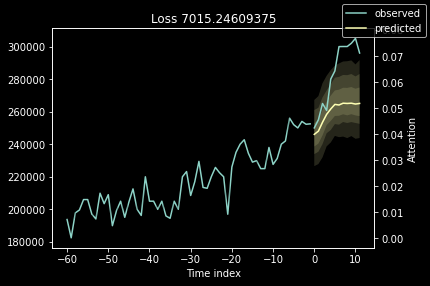

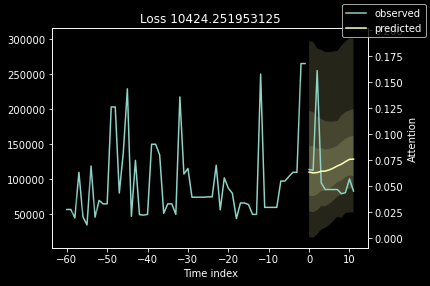

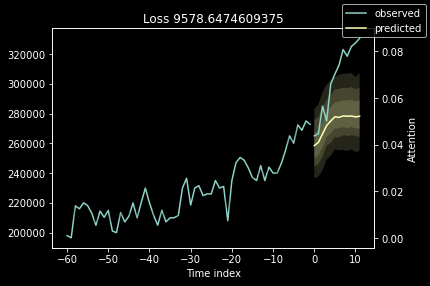

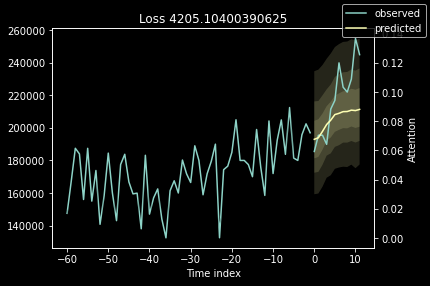

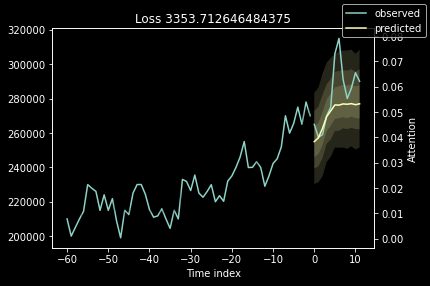

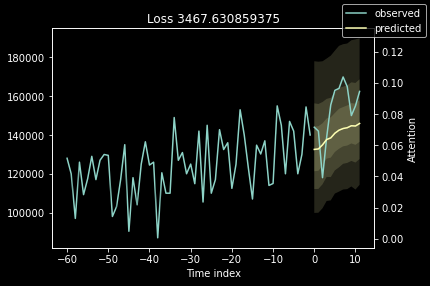

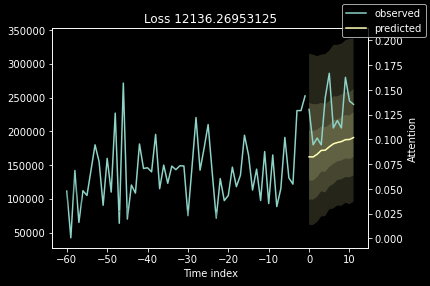

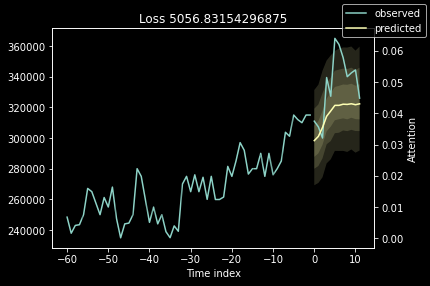

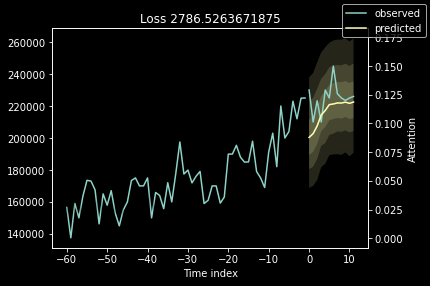

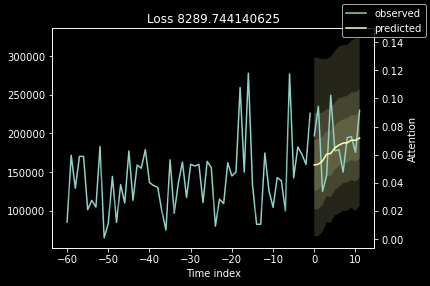

In [28]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True); #change back to best_tft

#### Worst Performers
- various metrics to choose from: https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.metrics.html#module-pytorch_forecasting.metrics

In [ ]:
# # calcualte metric by which to display
# predictions = best_tft.predict(val_dataloader)
# mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
# indices = mean_losses.argsort(descending=True)  # sort losses
# for idx in range(10):  # plot 10 examples
#     best_tft.plot_prediction(
#         x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
#     );

#### Actuals vs predictions by variable

In [ ]:
# predictions, x = best_tft.predict(val_dataloader, return_x=True)
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

#### Predict on selected data

In [ ]:
# change args to variables 
county = None
prop_type = None
# fips = None

In [27]:
# best_tft.predict(
#     training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
#     mode="quantiles",
# )

#### Model Interpretation

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x486 with 1 Axes>,
 'decoder_variables': <Figure size 504x288 with 1 Axes>}

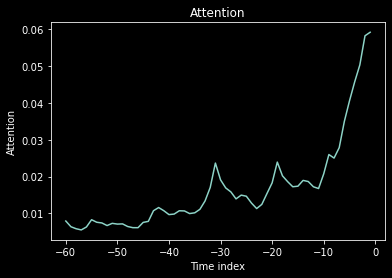

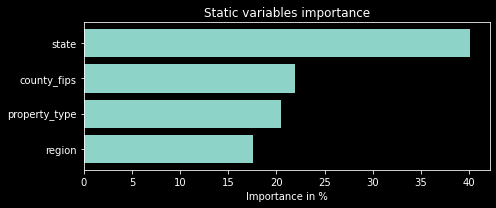

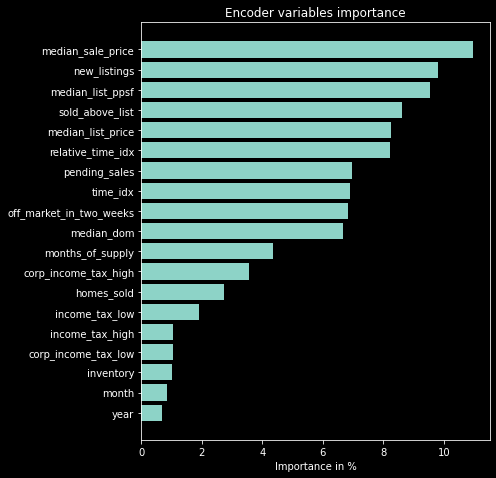

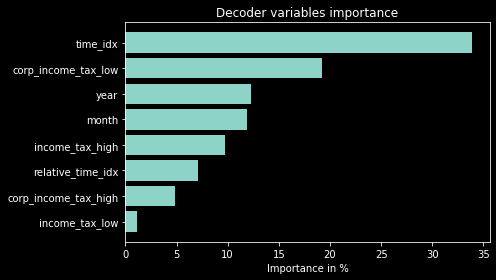

In [20]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
 # can look at partial dependency here later

In [21]:
interpretation

{'attention': tensor([ 36.4597,  29.3194,  26.8403,  25.3650,  29.0175,  38.0838,  34.9174,
          34.0376,  30.7993,  33.5593,  32.6330,  32.8731,  29.6089,  28.1621,
          28.1447,  34.7349,  36.0387,  49.3185,  53.2482,  49.3140,  44.4717,
          45.1004,  49.2334,  49.0293,  45.7486,  46.6917,  51.0735,  61.5357,
          78.3675, 108.6888,  87.7525,  77.7116,  72.7522,  64.0594,  68.7192,
          67.3784,  58.7972,  51.9833,  57.1929,  70.7572,  84.0680, 109.9019,
          92.7926,  85.5680,  79.1658,  79.8729,  87.0971,  85.6820,  79.1292,
          76.9672,  95.2870, 119.3421, 114.9296, 127.8774, 160.7360, 186.3837,
         209.9033, 231.0569, 267.3802, 271.7767]),
 'static_variables': tensor([ 801.5247,  930.2598, 1827.2007,  997.0149]),
 'encoder_variables': tensor([ 39.2068,  31.5723, 313.8257,  87.3786,  48.0638,  47.8005, 162.1766,
         374.9297, 499.4811, 375.9402, 434.7848, 124.1371, 317.7842, 446.8752,
          46.1639, 198.6727, 303.8460, 392.7341, 3